# Data Pre-Processing Notebook
This notebook contains the data processing for the project's F1 Kaggle datasets.

In [43]:
#Import general pytohn packages
import pandas as pd
import numpy as np

#Modelling packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from scipy.stats import jarque_bera, normaltest

#Import Python packages prepared for this project
from workflowpackages.data import get_kaggle_f1_data
#-------------------------
#For complete code regarding the package see 'workflowpackages' .py files
#You can also type ? and ?? after the imported function to see documentation and full source code in-line
#-------------------------

In [44]:
get_kaggle_f1_data(force_download=False)

No missing datasets. The following datasets are available:
- circuits.csv
- constructors.csv
- lap_times.csv
- races.csv
- sprint_results.csv
- constructor_results.csv
- driver_standings.csv
- pit_stops.csv
- results.csv
- status.csv
- constructor_standings.csv
- drivers.csv
- qualifying.csv
- seasons.csv


In [45]:
#READ DATA
#Read the dataframes from the source and label them
df_results = pd.read_csv('datasets/f1/results.csv')
df_races = pd.read_csv('datasets/f1/races.csv')
df_drivers = pd.read_csv('datasets/f1/drivers.csv')
#--------------------------------------------------

#SELECT COLUMNS
#Select columns to keep for modelling in the dataframes
#Results data
results_cols = [
    'resultId', #Unique id for a race result per driver
    'raceId',
    'driverId',
    'grid',
    'position', #Numeric, null if position text is R, D, or W - meaning the car was retired, disqualified, or withdrawn
    'positionText' #String, same as position, instead of null, indicates R, D, or W
]
#Races data
races_cols = [
    'raceId',
    'year'
]
#Drviers data
drivers_cols = [
    'driverId',
    'code' #Driver code based on driver last name
]
#---------------------------------------------------

#FILTER DATA
#Filter the dataframes by selected columns
df_results = df_results[results_cols]
df_races = df_races[races_cols]
df_drivers = df_drivers[drivers_cols]
#---------------------------------------------------

#JOIN THE DATA
#Join the races data to results dataframe
df_model = df_results.merge(
    df_races,
    how = 'inner',
    on = 'raceId',
)
#Join the drivers data to results dataframe
df_model = df_model.merge(
    df_drivers,
    how = 'inner',
    on = 'driverId',
)
#---------------------------------------------------

In [46]:
#Preview the dataset
df_model.head()

,resultId,raceId,driverId,grid,position,positionText,year,code
0,1,18,1,1,1,1,2008,HAM
1,27,19,1,9,5,5,2008,HAM
2,57,20,1,3,13,13,2008,HAM
3,69,21,1,5,3,3,2008,HAM
4,90,22,1,3,2,2,2008,HAM


In [48]:
#Filter races to analyze (limit historical period)
mask = (df_model['year'] >= 2020) & (df_model['year'] != 2024)
df_model = df_model[mask]

In [49]:
#CREATE DUMMY VARIABLES

#Get dummies for Finished Race
dummies_finished = pd.get_dummies(
    #Modify positionText column to indicate "finished_race" if the car finished the race, otherwise "out"
    df_model['positionText'].apply(lambda x: 'finished_race' if str.isnumeric(x) else 'Out'),
    prefix = 'Car'
).drop(
    ['Car_finished_race'],
    axis = 1
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_finished,
    how = 'inner',
    left_index = True,
    right_index = True
).drop(
    ['positionText'],
    axis = 1
)
#---------------------------------------------------

#Get dummies for Driver id
dummies_drivers = pd.get_dummies(
    df_model['driverId'],
    prefix = 'Driver'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_drivers,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#Get dummies for season
dummies_season = pd.get_dummies(
    df_model['year'],
    prefix = 'Season'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_season,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#CLEAN DATA COLUMNS
#Clean nulls and change datatypes
df_model['position'] = df_model['position'].apply(lambda x : 0 if x == '\\N' else x).astype('float')
df_model['grid'] = df_model['grid'].astype('float')

In [50]:
#MODELLING

#Feature Selection
#Define model dataset
model_cols = [
    'grid',
    'Car_Out'
]

#Append Driver Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for driver in dummies_drivers.columns[:len(dummies_drivers.columns) -1]:
    model_cols.append(driver)
    
#Append Season Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for driver in dummies_season.columns[:len(dummies_season.columns) -1]:
    model_cols.append(driver)
#---------------------------------------------------

#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[model_cols].astype(float), 
    df_model['position'].astype(float),
    test_size = 0.3,
    random_state = 37 #Because 37 is a fantabulous number
)
#----------------------------------------------------

In [51]:

#Check Dataset info
X_train.info()
#----------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162 entries, 24677 to 23400
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   grid         1162 non-null   float64
 1   Car_Out      1162 non-null   float64
 2   Driver_1     1162 non-null   float64
 3   Driver_4     1162 non-null   float64
 4   Driver_8     1162 non-null   float64
 5   Driver_9     1162 non-null   float64
 6   Driver_20    1162 non-null   float64
 7   Driver_154   1162 non-null   float64
 8   Driver_807   1162 non-null   float64
 9   Driver_815   1162 non-null   float64
 10  Driver_817   1162 non-null   float64
 11  Driver_822   1162 non-null   float64
 12  Driver_825   1162 non-null   float64
 13  Driver_826   1162 non-null   float64
 14  Driver_830   1162 non-null   float64
 15  Driver_832   1162 non-null   float64
 16  Driver_839   1162 non-null   float64
 17  Driver_840   1162 non-null   float64
 18  Driver_841   1162 non-null   float64
 19  D

In [52]:

#Preview model dataset
X_train.head()
#----------------------------------------------------

,grid,Car_Out,Driver_1,Driver_4,Driver_8,Driver_9,Driver_20,Driver_154,Driver_807,Driver_815,...,Driver_852,Driver_853,Driver_854,Driver_855,Driver_856,Driver_857,Driver_858,Season_2020,Season_2021,Season_2022
24677,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25146,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25641,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3653,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25217,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:

#Do a simple Linear regression

#Uncomment/Comment the next lines of code to add a constant. 
#The model appears to perform better without constant.
#X = sm.add_constant(X_train) 
X = X_train 

slm = sm.OLS(y_train,X).fit()
slm_predictions = slm.predict(X)

print_model = slm.summary()
print(print_model)
#----------------------------------------------------

                                 OLS Regression Results                                
Dep. Variable:               position   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              226.5
Date:                Thu, 11 Apr 2024   Prob (F-statistic):                        0.00
Time:                        21:09:15   Log-Likelihood:                         -3058.1
No. Observations:                1162   AIC:                                      6190.
Df Residuals:                    1125   BIC:                                      6377.
Df Model:                          37                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

The mean of the residuals is:  0.025079969664240812
This is their JB test result --> 'statistic' : 149.99230925366456 'p-value' : 2.688957150278055e-33
This is their Normaltest result --> 'statistic' : 106.76358386693529 'p-value' : 6.555145399206725e-24


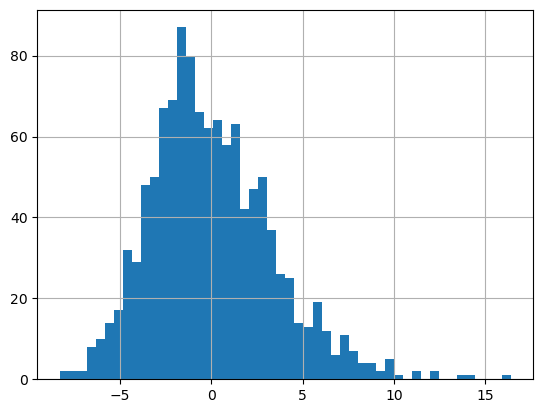

In [69]:

#Evaluate OLS normality assumptions
#Calculate residuals

slm_residuals = y_train - slm_predictions

#Check model normality
jb = jarque_bera(slm_residuals)
nt = normaltest(slm_residuals)

print('The mean of the residuals is: ',np.mean(slm_residuals))
print('This is their JB test result -->','\'statistic\' :', jb[0],'\'p-value\' :',jb[1])
print('This is their Normaltest result -->','\'statistic\' :', nt[0],'\'p-value\' :',nt[1])

slm_residuals.hist(bins=50);
#----------------------------------------------------

The model suffices two fundamental assumptions in the linear model:
1. The mean of $e$ (the error term) is cero, and
2. There is no multicorrelation of the error terms (the Durbin Watson test in 2)

In [71]:

#Visualize position and predictions in a dataframe
slm_predictions.name = 'predictions'
df_slm_results = y_train.to_frame().join(slm_predictions)
df_slm_results.head()
#----------------------------------------------------

,position,predictions
24677,5.0,8.115307
25146,0.0,-2.363290
25641,0.0,-1.955206
3653,11.0,10.171761
25217,4.0,10.868813


In [74]:

#Round results and visualize in a matrix form

#Round results
df_slm_results['predictions'] = df_slm_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)
# Create a categorical column based on rounded predictions
df_slm_results['predictions_category'] = df_slm_results['predictions'].round()

#Visualize matrix
pd.pivot_table(
    df_slm_results,
    index='position',
    columns='predictions_category',
    values='predictions',
    aggfunc='count',
    margins=True
)

predictions_category,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,All
position,,,,,,,,,,,,,,,,,,,,
0.0,86.0,17.0,16.0,15.0,14.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158
1.0,NaN,NaN,7.0,26.0,6.0,5.0,4.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
2.0,NaN,NaN,6.0,7.0,9.0,13.0,9.0,9.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
3.0,NaN,NaN,3.0,1.0,5.0,12.0,12.0,14.0,9.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61
4.0,NaN,NaN,NaN,NaN,3.0,11.0,10.0,12.0,11.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
5.0,NaN,NaN,NaN,NaN,NaN,7.0,13.0,11.0,19.0,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
6.0,NaN,NaN,1.0,1.0,NaN,4.0,8.0,13.0,17.0,9.0,6.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,63
7.0,NaN,NaN,NaN,1.0,1.0,2.0,10.0,10.0,13.0,5.0,7.0,2.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,54
8.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,14.0,13.0,12.0,6.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,62


In [ ]:

#Instantiate Standard Scaler
ss = StandardScaler()
ss.fit(X_train)

Xs_train = ss.transform(X_train)
